In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
from functools import partial
from tqdm import tqdm

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import numpy as np
import re

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from timm.utils import accuracy
from torch.utils.tensorboard import SummaryWriter

from get_models import get_model

writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

/private/home/sshkhr/.conda/envs/pytorch_env/lib/python3.9/site-packages/MinkowskiEngine-0.5.4-py3.9-linux-x86_64.egg/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [2]:
import itertools

In [3]:
from ast import literal_eval

### Linear probes eval

In [4]:
resultsp = {'MAE': {}, 'MoCo': {}, 'DINO': {}, 'MAE_FT': {}}

for key in resultsp:
    folder_name = "/checkpoint/sshkhr/hyper_sweep_all/logs/" + key + '/vit_base_patch16/'

    log_files_list = []
    for root, dirs, files in os.walk(folder_name):
        if root[len(folder_name):].count(os.sep) < 3:
            for file in files:
                if file == 'log.txt':
                    log_file = os.path.join(root, file)  
                    log_files_list.append(log_file)   

    for log_file in log_files_list:            
        log_list = []
        print(log_file)
        if os.path.isfile(log_file): 
            with open(log_file, "r") as log:
                for line in log:
                    log_dict = literal_eval(line)
                    log_list.append(log_dict)
                
        df = pd.DataFrame(log_list)
        df = df.set_index('epoch')
        #print(log_file.split('/')[-4])
        try:
            resultsp[key][log_file.split('/')[-4]][log_file.split('/')[-3]] = df
        except KeyError:
            resultsp[key][log_file.split('/')[-4]] = {}
            resultsp[key][log_file.split('/')[-4]][log_file.split('/')[-3]] = df

/checkpoint/sshkhr/hyper_sweep_all/logs/MAE/vit_base_patch16/all/blr_0.5_epochs_100_l1_reg_0/2989615_0/log.txt
/checkpoint/sshkhr/hyper_sweep_all/logs/MAE/vit_base_patch16/all/blr_0.5_epochs_200_l1_reg_0/2989615_1/log.txt
/checkpoint/sshkhr/hyper_sweep_all/logs/MAE/vit_base_patch16/all/blr_0.5_epochs_100_l1_reg_0.0001/2989615_2/log.txt
/checkpoint/sshkhr/hyper_sweep_all/logs/MAE/vit_base_patch16/all/blr_0.5_epochs_200_l1_reg_0.0001/2989615_3/log.txt
/checkpoint/sshkhr/hyper_sweep_all/logs/MAE/vit_base_patch16/all/blr_0.5_epochs_100_l1_reg_0.001/2989615_4/log.txt
/checkpoint/sshkhr/hyper_sweep_all/logs/MAE/vit_base_patch16/all/blr_0.5_epochs_200_l1_reg_0.001/2989615_5/log.txt
/checkpoint/sshkhr/hyper_sweep_all/logs/MAE/vit_base_patch16/all/blr_0.5_epochs_100_l1_reg_0.01/2989615_6/log.txt
/checkpoint/sshkhr/hyper_sweep_all/logs/MAE/vit_base_patch16/all/blr_0.5_epochs_200_l1_reg_0.01/2989615_7/log.txt
/checkpoint/sshkhr/hyper_sweep_all/logs/MAE/vit_base_patch16/all/blr_0.1_epochs_100_l1_r

In [5]:
df= {}
df_all = {}
for model in resultsp:
    df[model] = {}
    df_all[model] = {}
    for intermediate in resultsp[model]:
        top_1 = [resultsp[model][intermediate][exp]['test_acc1'].max() for exp in resultsp[model][intermediate]]
        best = sorted(top_1, reverse=True)[:5]
        if intermediate in ['1','2','3','4']:
            intermediate = int(intermediate)
        df[model][intermediate] = np.mean(best)
        df_all[model][intermediate] = best

In [6]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Probe'}, inplace=True)
df = df.melt(id_vars=['Probe'], value_name='Top-1', var_name='Model')
df.dropna(inplace=True)

In [7]:
df_all = pd.DataFrame.from_dict(df_all)
df_all.reset_index(inplace=True)
df_all.rename(columns={'index':'Probe'}, inplace=True)
df_all = df_all.melt(id_vars=['Probe'], value_name='Top-1', var_name='Model')
df_all.dropna(inplace=True)
df_all = df_all.explode('Top-1')

In [9]:
df[(df['Probe'].isin([1,2,3,4])) & (df['Model'].isin(['MAE','MoCo','DINO']))]

,Probe,Model,Top-1
13,1,MAE,67.7300
14,2,MAE,68.3388
15,3,MAE,69.0556
16,4,MAE,68.8944
30,1,MoCo,76.3352
31,2,MoCo,76.8168
32,3,MoCo,76.2988
33,4,MoCo,76.2128
47,1,DINO,77.7828
48,2,DINO,78.3280


In [8]:
fig_dir = '../figures/ICML/'

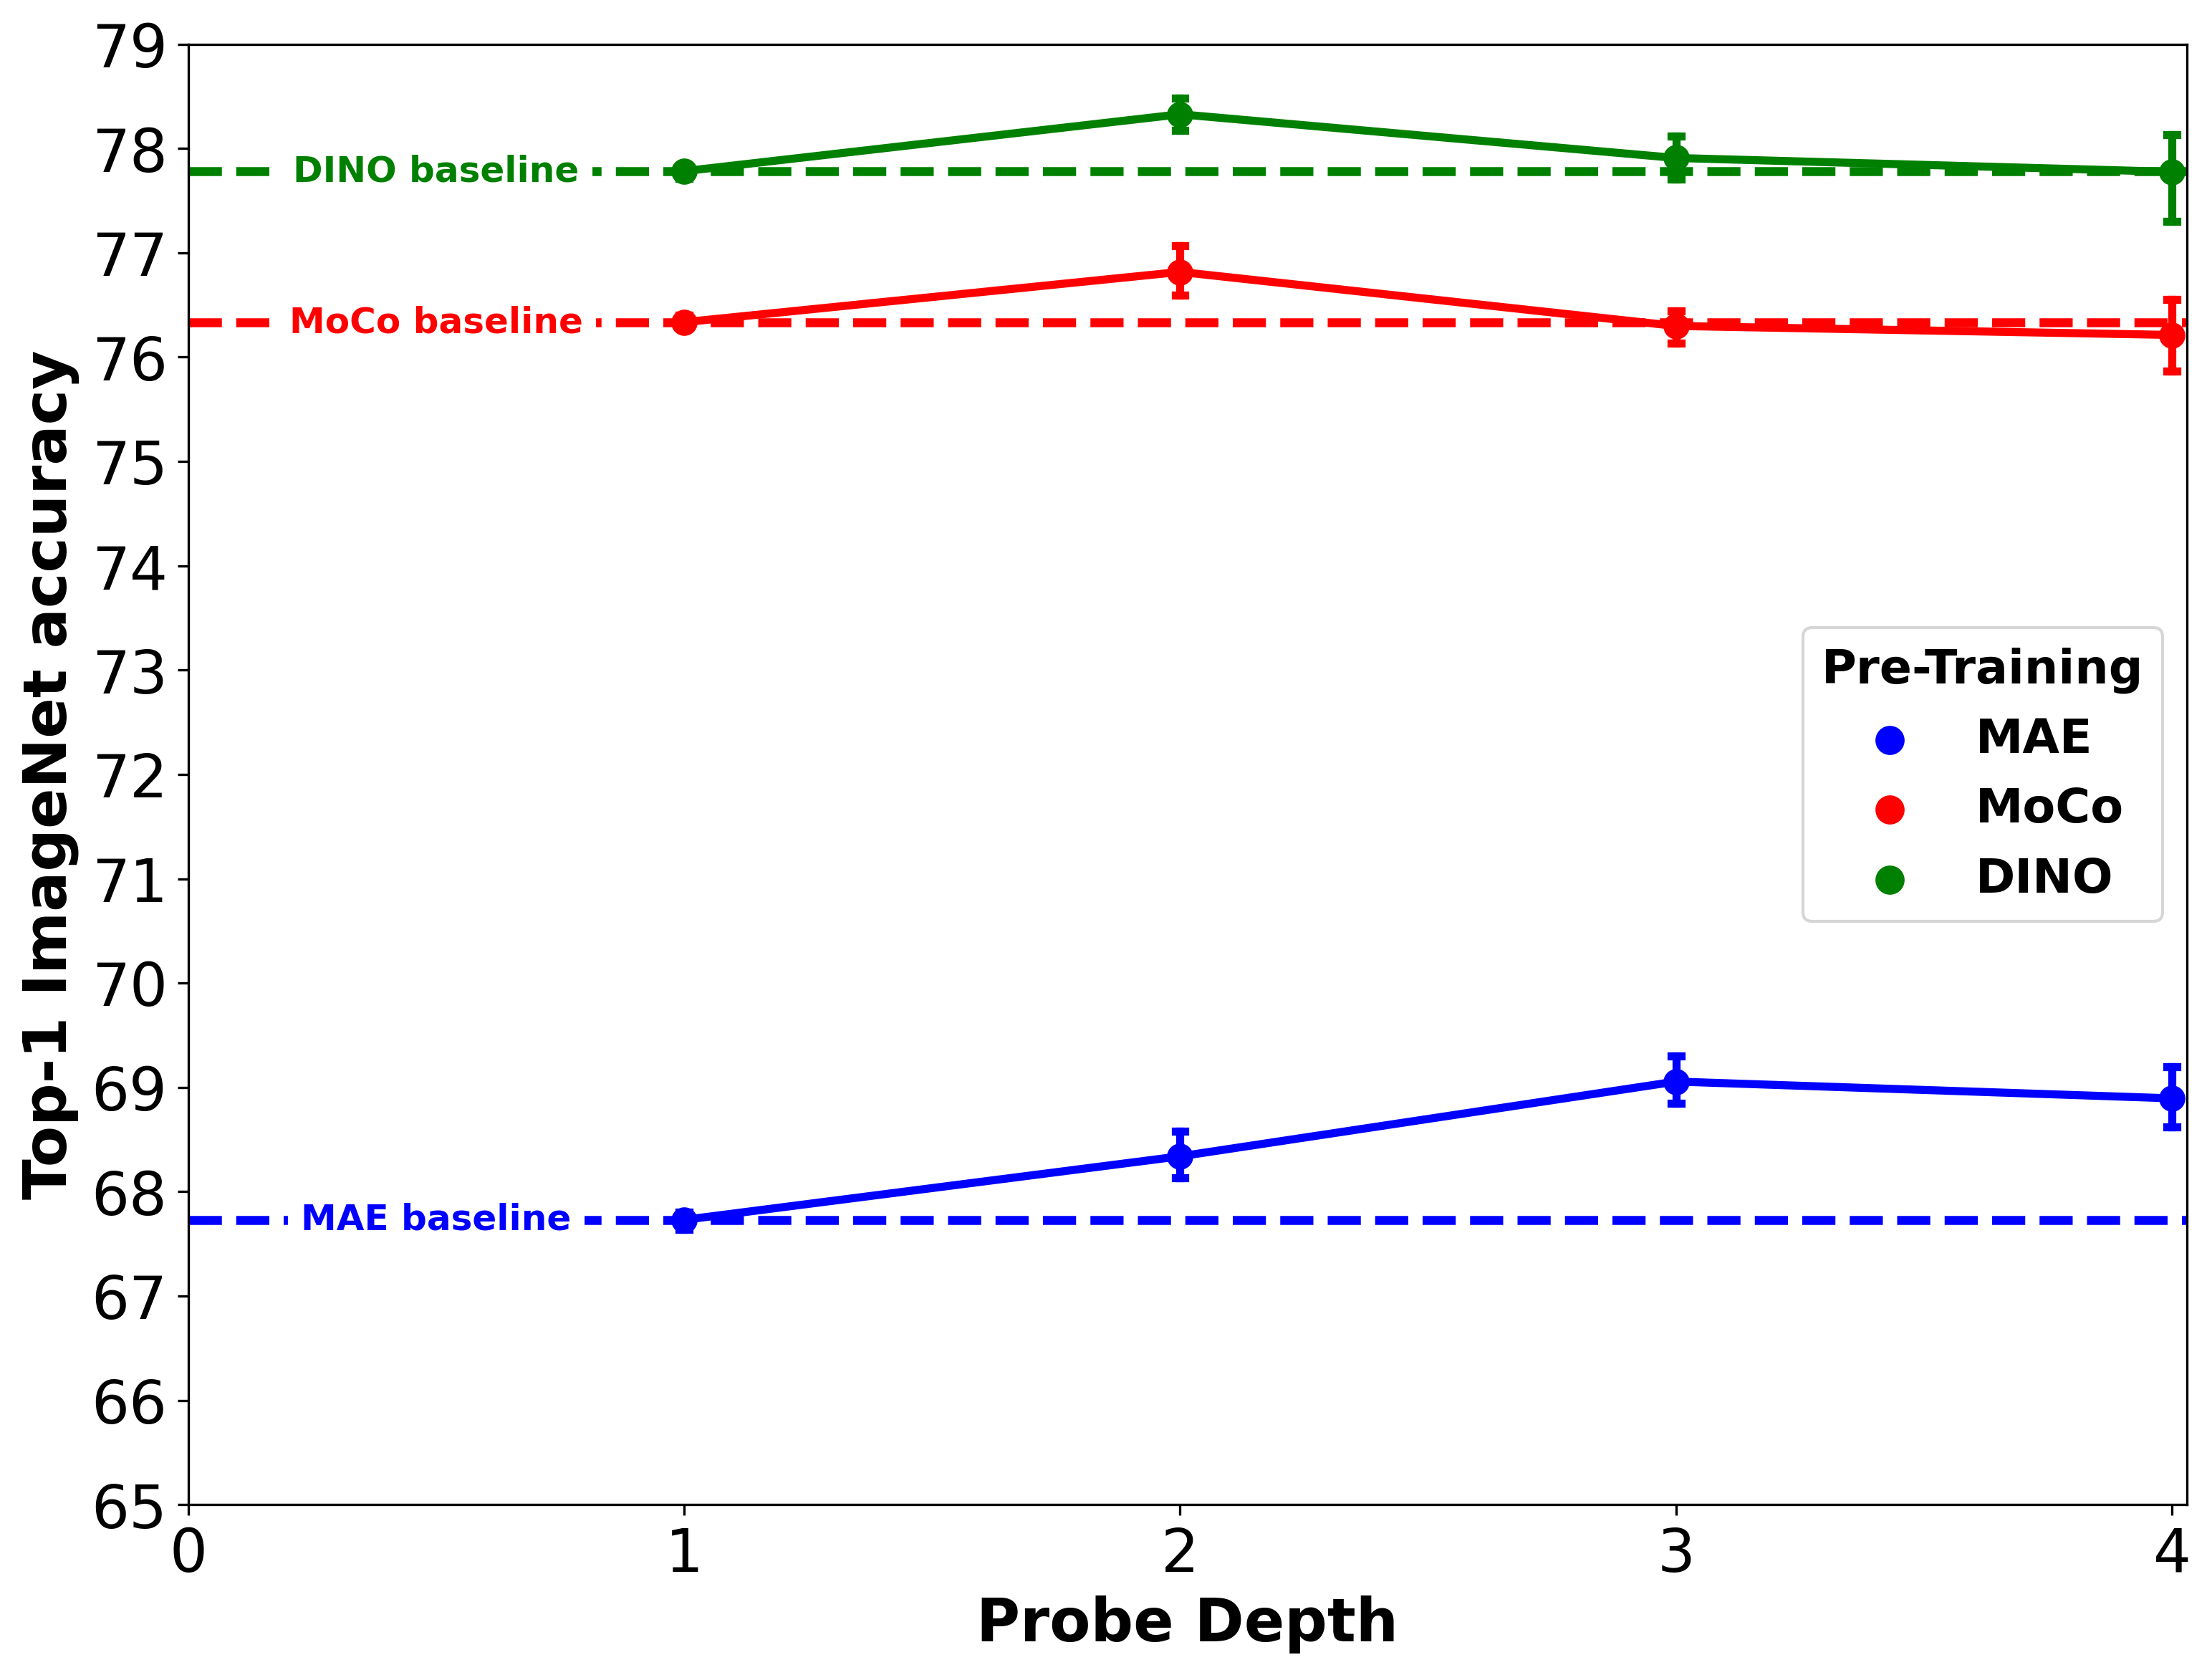

In [9]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

data = df[(df['Probe'].isin([1,2,3,4])) & (df['Model'].isin(['MAE','MoCo','DINO']))]
#sns.lineplot(data=data, x='Probe', y='Top-1', hue='Model', marker="o", palette=['b', 'r', 'g'], linewidth = 3, estimator='mean', ci='sd', err_style='bars')
data_2 = df_all[(df_all['Probe'].isin([1,2,3,4])) & (df_all['Model'].isin(['MAE','MoCo','DINO']))]
sns.pointplot(data=data_2, x='Probe', y='Top-1', hue='Model', marker="o", palette=['b', 'r', 'g'], errorbar="sd", capsize=.02)
#data_2.groupby('Probe')['Top-1'].agg([min, max]).plot(ax=ax)

plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(-0.5, (df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MAE baseline', fontsize=12, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Probe'] == 1)]['Top-1'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(-0.5, (df[(df['Model'] == 'MoCo') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MoCo baseline', fontsize=12, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Probe'] == 1)]['Top-1'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(-0.5, (df[(df['Model'] == 'DINO') & (df['Probe'] == 1)]['Top-1'].values[0]), 'DINO baseline', fontsize=12, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='w')


ax.set_xlabel("Probe Depth", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 ImageNet accuracy", fontweight="bold", fontsize = 20)

# hack because pointplot is shifted to left while lineplot is not
plt.xlim([-1, 3.03])
plt.ylim([65, 79])

ax.set_xticks(np.arange(-1, 4, 1), visible=True)
ax.set_yticks(np.arange(65, 80, 1), visible=True)
ax.set_xticklabels([x for x in np.arange(0, 5, 1)], fontsize = 20)
ax.set_yticklabels([x for x in np.arange(65, 80, 1)], fontsize = 20)

legend = plt.legend(loc=5, title="Pre-Training", prop={'size': 16, 'weight':'bold'})
plt.setp(legend.get_title(),fontsize=16, fontweight='bold')
for legobj in legend.legendHandles:
    legobj.set_linewidth(3)

fig.savefig(fig_dir + 'arxiv_deep_probes.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

### Intermediate probes eval

In [45]:
cols = [1] + ['blocks.'+str(i) for i in range(12)] + ['all']
data_2 = df_all[(df_all['Probe'].isin(cols)) & (df_all['Model'].isin(['MAE','MoCo','DINO']))]
grouped = data_2.groupby(['Model', 'Probe'])
grouped.agg(['mean', 'std'])

Top-1          
                    mean       std
Model Probe                       
DINO  1          77.7828  0.073574
      all        77.2440  0.071358
      blocks.0   77.6184  0.084704
      blocks.1   77.6492  0.128098
      blocks.10  77.8436  0.145955
      blocks.11  77.8488  0.084624
      blocks.2   77.6096  0.059840
      blocks.3   77.5572  0.105855
      blocks.4   77.6116  0.071476
      blocks.5   77.6060  0.073661
      blocks.6   77.6868  0.019318
      blocks.7   77.7500  0.029428
      blocks.8   77.8520  0.042685
      blocks.9   77.9776  0.058709
MAE   1          67.7300  0.105148
      all        70.1204  0.040655
      blocks.0   67.3924  0.081663
      blocks.1   67.1408  0.106222
      blocks.10  69.4372  0.132594
      blocks.11  67.5244  0.035816
      blocks.2   67.2496  0.107382
      blocks.3   67.5604  0.163826
      blocks.4   67.8240  0.099227
      blocks.5   67.9244  0.146597
      blocks.6   68.2400  0.164779
      blocks.7   68.6044  0.122584
      blocks.8   69.2188  0.078697
      blocks.9   69.5380  0.068293
MoCo  1          76.3352  0.076793
      all        75.7764  0.188523
      blocks.0   76.3016  0.135922
      blocks.1   76.2328  0.172758
      blocks.10  76.6136  0.025432
      blocks.11  76.4152  0.021005
      blocks.2   76.2444  0.136487
      blocks.3   76.1036  0.139301
      blocks.4   76.0604  0.136194
      blocks.5   76.1808  0.118883
      blocks.6   76.3448  0.137714
      blocks.7   76.2800  0.087441
      blocks.8   76.4608  0.092958
      blocks.9   76.5540  0.045717

/tmp/ipykernel_1563810/2610378461.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace({1:'None', 'all':'All'}, inplace=True)
/tmp/ipykernel_1563810/2610378461.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2.replace({1:'None', 'all':'All'}, inplace=True)


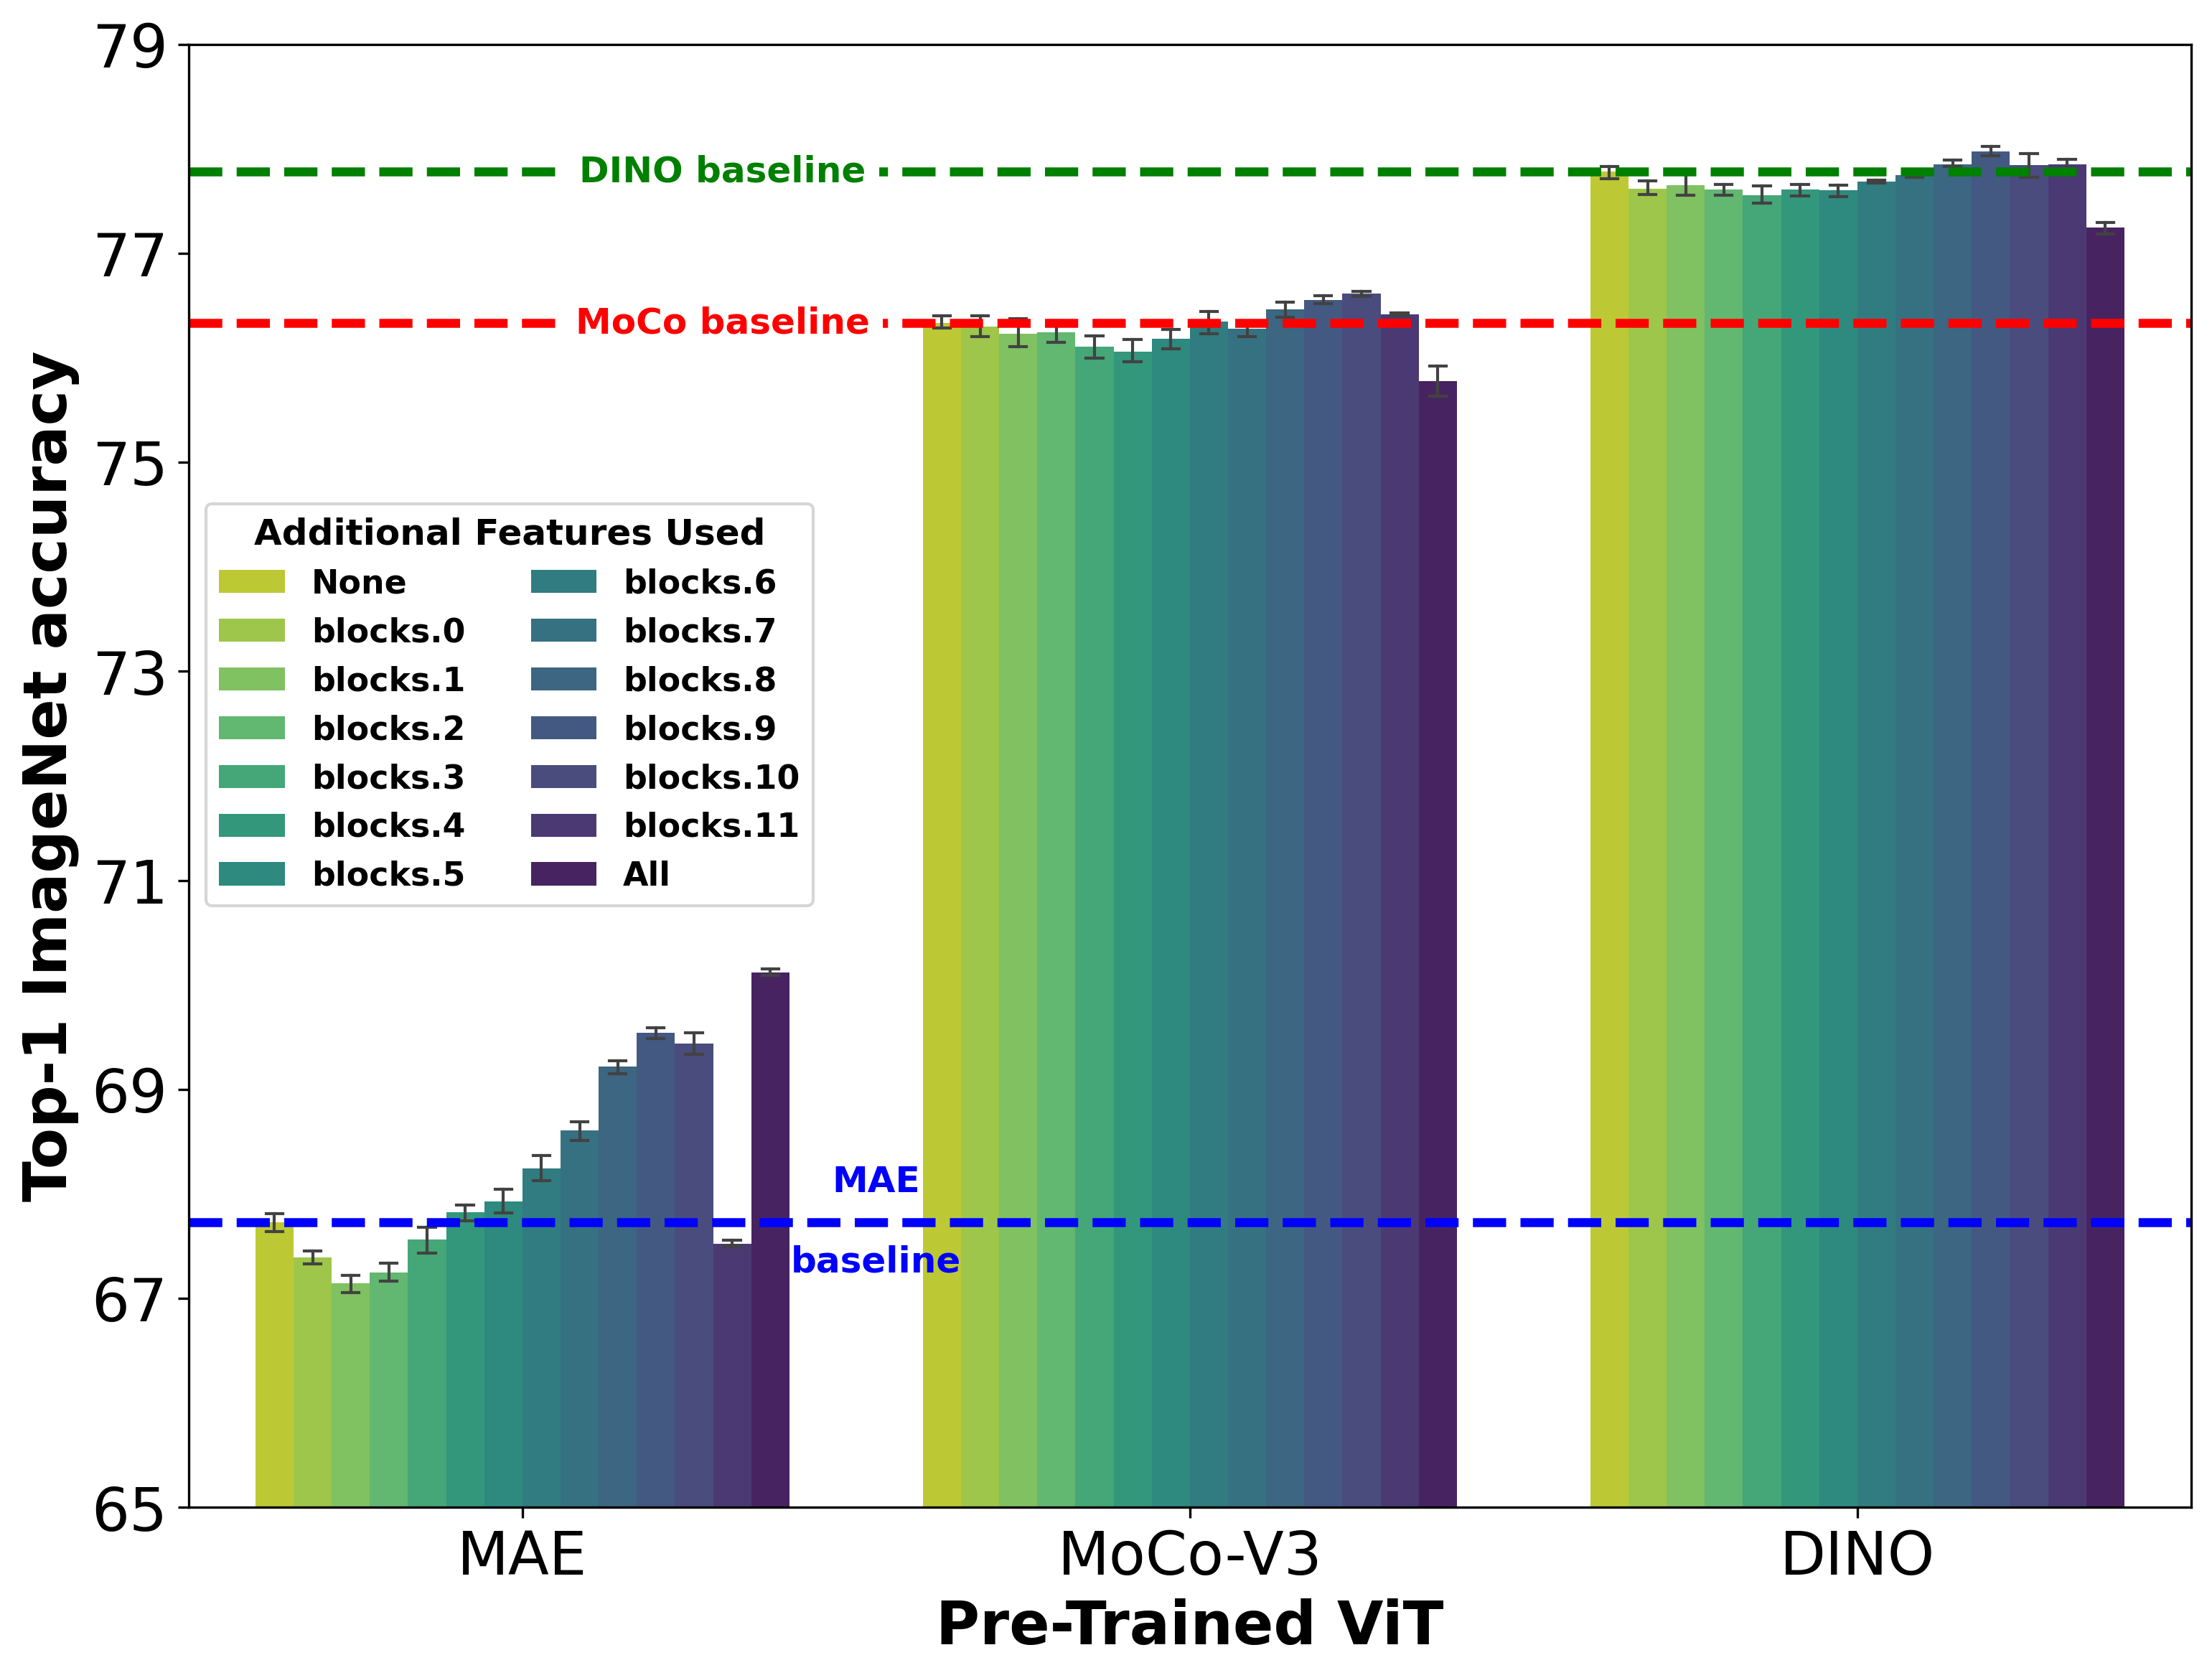

In [34]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

cols = [1] + ['blocks.'+str(i) for i in range(12)] + ['all']
data = df[(df['Probe'].isin(cols)) & (df['Model'].isin(['MAE','MoCo','DINO']))]

data.replace({1:'None', 'all':'All'}, inplace=True)
hue_order = ['None'] + ['blocks.'+str(i) for i in range(12)] + ['All']

data_2 = df_all[(df_all['Probe'].isin(cols)) & (df_all['Model'].isin(['MAE','MoCo','DINO']))]

data_2.replace({1:'None', 'all':'All'}, inplace=True)
hue_order = ['None'] + ['blocks.'+str(i) for i in range(12)] + ['All']

plot = sns.barplot(data=data_2, x='Model', y='Top-1', hue='Probe', hue_order = hue_order, palette=reversed(sns.color_palette("viridis", 14)), errwidth=1, capsize=0.025)

plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.53, (df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MAE\n\nbaseline', fontsize=12, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='none')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Probe'] == 1)]['Top-1'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(0.3, (df[(df['Model'] == 'MoCo') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MoCo baseline', fontsize=12, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Probe'] == 1)]['Top-1'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(0.3, (df[(df['Model'] == 'DINO') & (df['Probe'] == 1)]['Top-1'].values[0]), 'DINO baseline', fontsize=12, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='w')

ax.set_xlabel("Pre-Trained ViT", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 ImageNet accuracy", fontweight="bold", fontsize = 20)

plt.ylim([65, 79])

ax.set_xticklabels(['MAE', 'MoCo-V3', 'DINO'], fontsize = 20)
ax.set_yticks(np.arange(65, 80, 2), visible=True)
ax.set_yticklabels([x for x in np.arange(65, 80, 2)], fontsize = 20)

legend = plt.legend(loc='best', title="Additional Features Used", prop={'size': 11, 'weight':'bold'}, ncol=2, bbox_to_anchor=(.32, .4))
plt.setp(legend.get_title(),fontsize=12, fontweight='bold')

fig.savefig(fig_dir + 'arxiv_marginal_features.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

## Fine-Tuned MAE

/tmp/ipykernel_1563810/257714541.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace({1:'None', 'all':'All'}, inplace=True)
/tmp/ipykernel_1563810/257714541.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2.replace({1:'None', 'all':'All'}, inplace=True)


AxesSubplot(0.125,0.125;0.775x0.755)


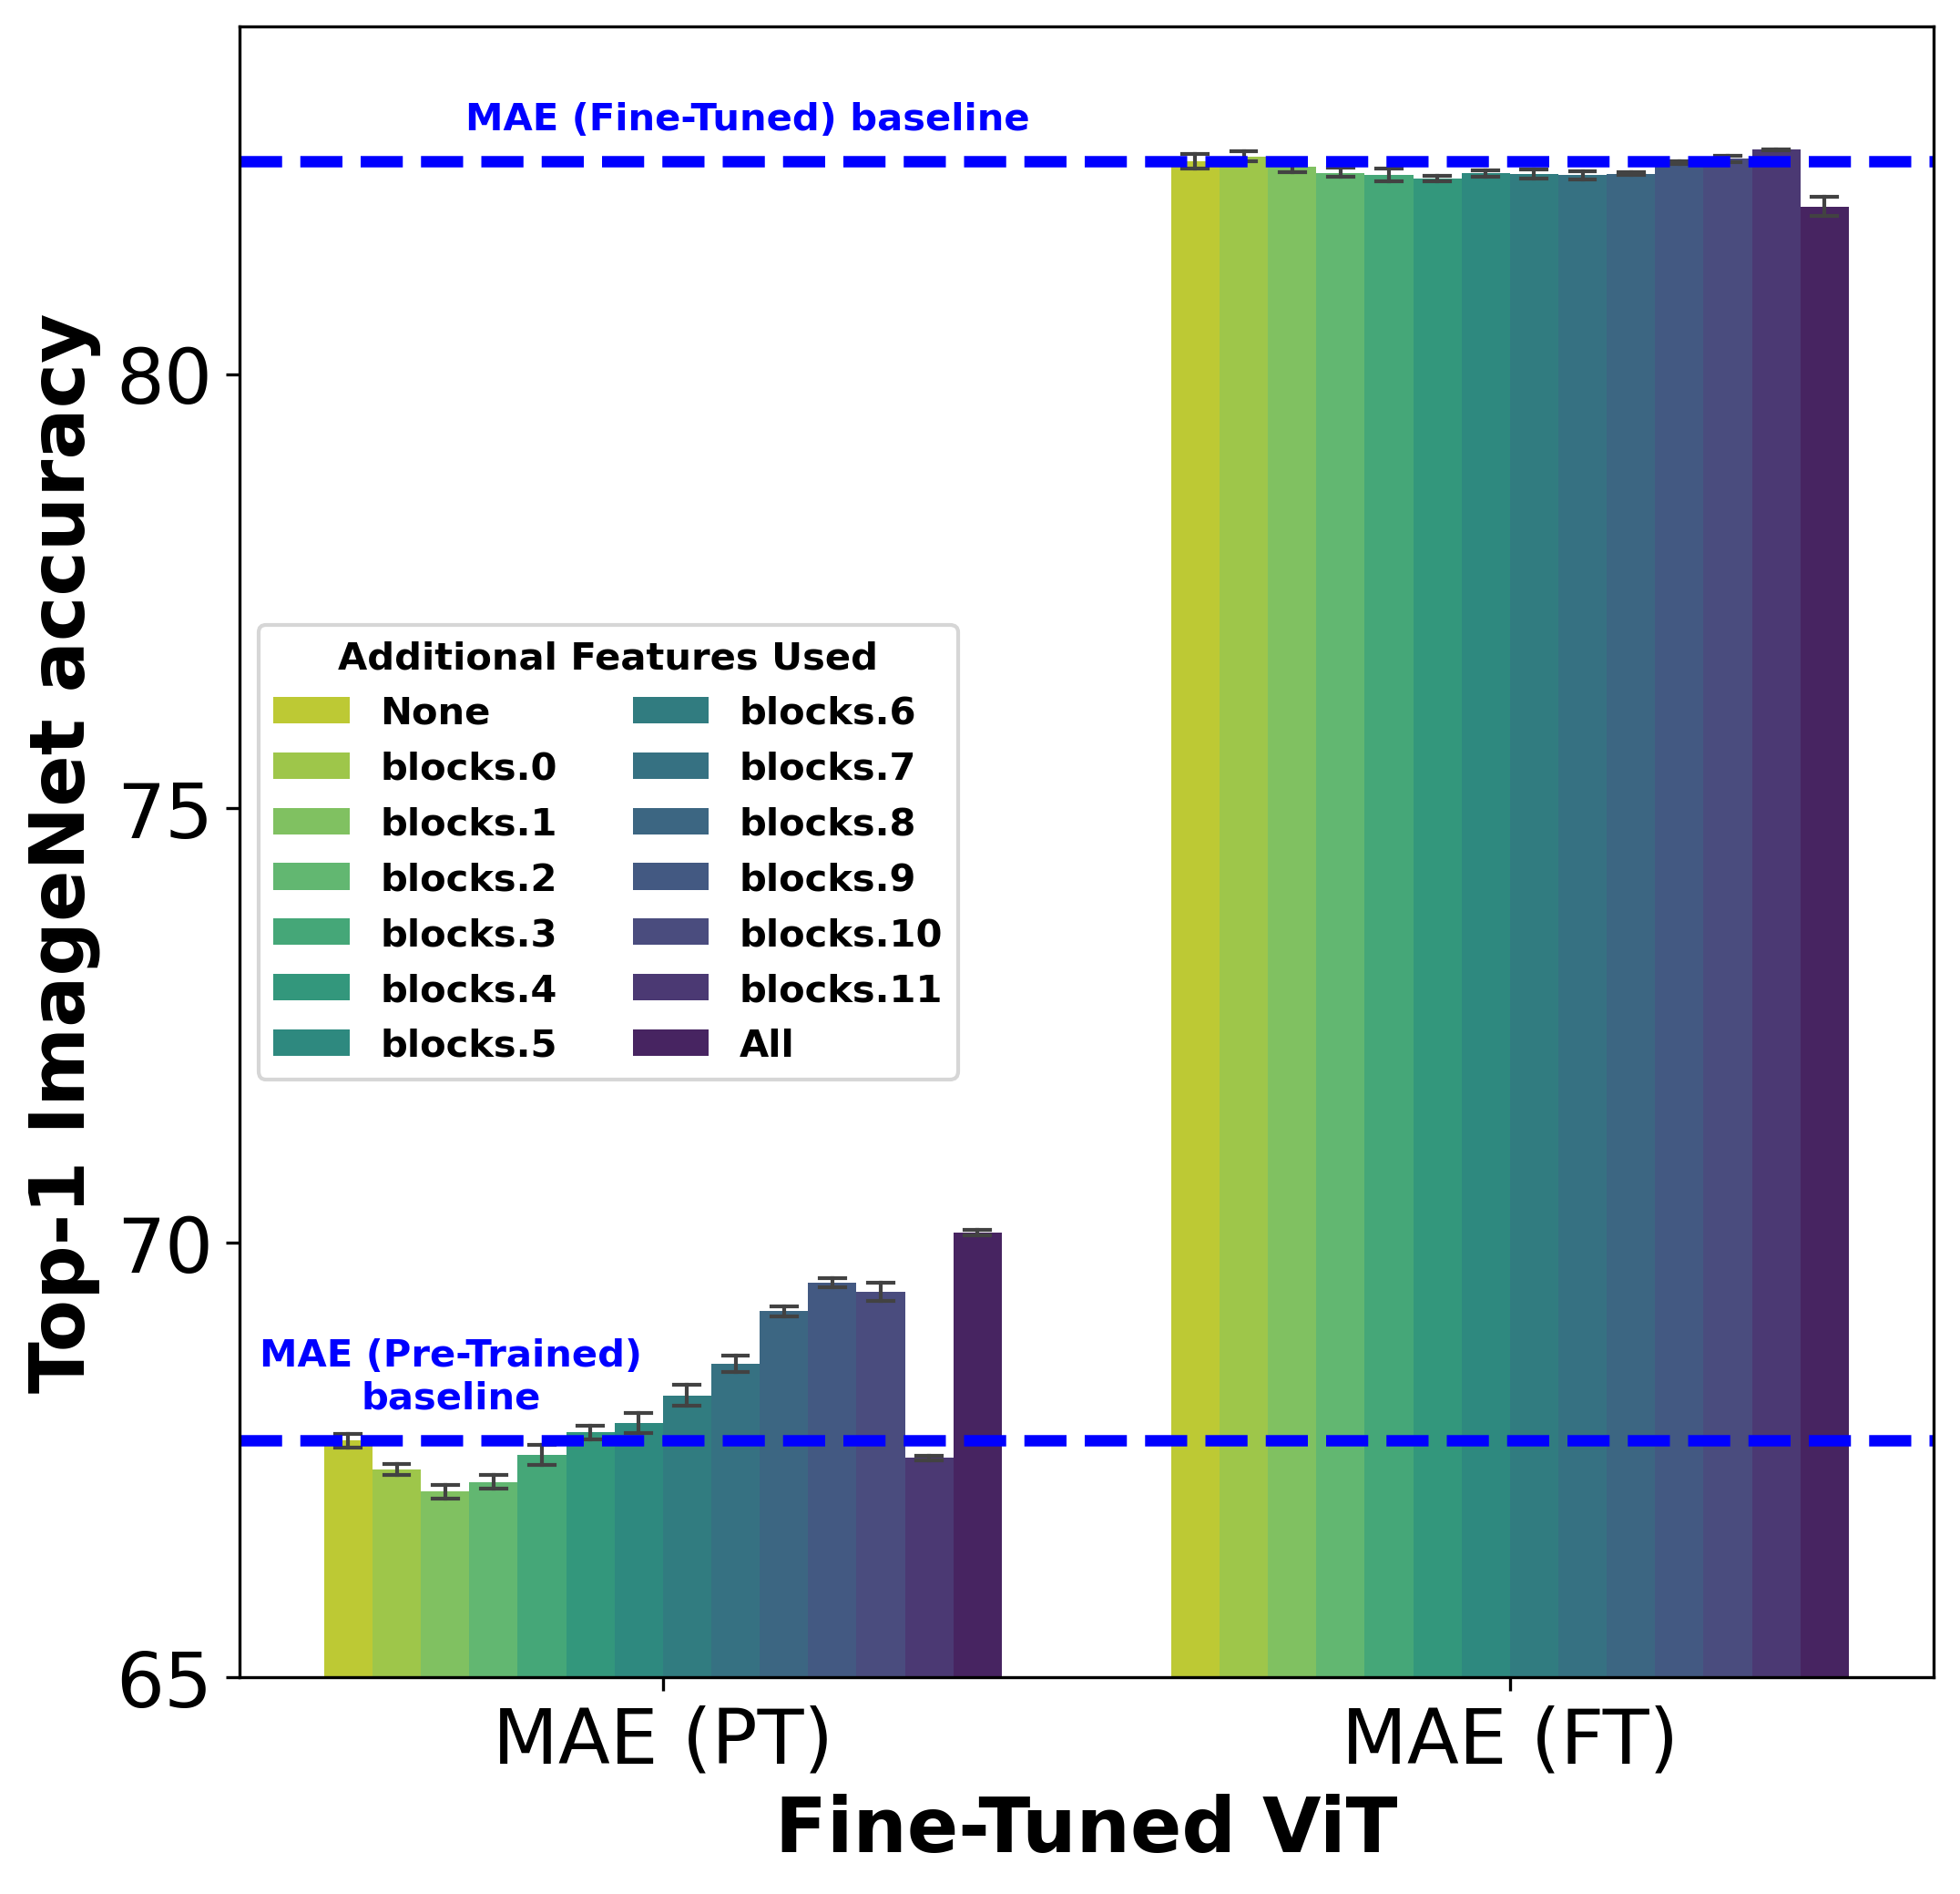

In [35]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=300, sharex=True)

cols = [1] + ['blocks.'+str(i) for i in range(12)] + ['all']
data = df[(df['Probe'].isin(cols)) & (df['Model'].isin(['MAE','MAE_FT']))]

data.replace({1:'None', 'all':'All'}, inplace=True)
hue_order = ['None'] + ['blocks.'+str(i) for i in range(12)] + ['All']

data_2 = df_all[(df_all['Probe'].isin(cols)) & (df_all['Model'].isin(['MAE','MAE_FT']))]

data_2.replace({1:'None', 'all':'All'}, inplace=True)
hue_order = ['None'] + ['blocks.'+str(i) for i in range(12)] + ['All']

plot = sns.barplot(data=data_2, x='Model', y='Top-1', hue='Probe', hue_order = hue_order, palette=reversed(sns.color_palette("viridis", 14)), errwidth=1, capsize=0.03)
print(plot)
plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(-0.25, (df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MAE (Pre-Trained)\nbaseline\n\n\n', fontsize=10, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='none')
plt.axhline(y=(df[(df['Model'] == 'MAE_FT') & (df['Probe'] == 1)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.1, (df[(df['Model'] == 'MAE_FT') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MAE (Fine-Tuned) baseline\n\n', fontsize=10, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='none')

ax.set_xlabel("Fine-Tuned ViT", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 ImageNet accuracy", fontweight="bold", fontsize = 20)

plt.ylim([65, 84])

ax.set_xticklabels(['MAE (PT)', 'MAE (FT)'], fontsize = 20)
ax.set_yticks(np.arange(65, 85, 5), visible=True)
ax.set_yticklabels([x for x in np.arange(65, 85, 5)], fontsize = 20)

legend = plt.legend(loc='best', title="Additional Features Used", prop={'size': 10, 'weight':'bold'}, ncol=2)
plt.setp(legend.get_title(),fontsize=10, fontweight='bold')

#ax.legend(title="Additional\nFeat. Used", prop={'size': 10}, bbox_to_anchor=(1.05, .75))
#plt.setp(legend.get_title(),fontsize=10)

fig.savefig(fig_dir + 'arxiv_mae_ft_marginal_features.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

### Detection & Segmentation

In [22]:
resultsint = {'MAE': {}, 'MoCo': {}, 'DINO': {}}

for key in resultsint:

    folder_name = "/checkpoint/sshkhr/experiments/detectron/" + key.lower() + '-pt/output/'
    log_file = folder_name + "metrics.json"
        
    log_list = []
    print(log_file)
    if os.path.isfile(log_file):
        with open(log_file, "r") as log:
            for line in log:
                log_dict = literal_eval(line)
                if "bbox/AP" in log_dict.keys():
                    log_list.append(log_dict)
    
    df = pd.DataFrame(log_list)
    df = df.set_index('iteration')
    resultsint[key]['None'] = df
                    
    for i in range(9,12):
        folder_name = "/checkpoint/sshkhr/experiments/detectron/multi/" + key.lower() + '-pt/block'+str(i)+'-block11/output/'
        log_file = folder_name + "metrics.json"
            
        log_list = []
        print(log_file)
        if os.path.isfile(log_file):
            with open(log_file, "r") as log:
                for line in log:
                    log_dict = literal_eval(line)
                    if "bbox/AP" in log_dict.keys():
                        log_list.append(log_dict)
                
        df = pd.DataFrame(log_list)
        df = df.set_index('iteration')
        resultsint[key][i] = df

/checkpoint/sshkhr/experiments/detectron/mae-pt/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/mae-pt/block9-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/mae-pt/block10-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/mae-pt/block11-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/moco-pt/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/moco-pt/block9-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/moco-pt/block10-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/moco-pt/block11-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/dino-pt/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/dino-pt/block9-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/dino-pt/block10-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/dino-pt/block11-block11/o

In [23]:
df= {}
for key in resultsint:
    df[key] = {}
    for k in resultsint[key]:
        if k=='None':
            df[key]['None'] = resultsint[key][k]['bbox/AP'].max()
        else:
            df[key]['Block.'+str(k)] = resultsint[key][k]['bbox/AP'].max()

In [24]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Intermediate Features'}, inplace=True)
df = df.melt(id_vars=['Intermediate Features'], value_name='bbox/AP', var_name='Model')

In [25]:
df

,Intermediate Features,Model,bbox/AP
0,None,MAE,30.277264
1,Block.9,MAE,31.460068
2,Block.10,MAE,31.714337
3,Block.11,MAE,30.469100
4,None,MoCo,28.750739
5,Block.9,MoCo,29.960781
6,Block.10,MoCo,20.324329
7,Block.11,MoCo,28.921014
8,None,DINO,32.568707
9,Block.9,DINO,33.475884


In [26]:
df.loc[((df.Model=='MoCo') & (df['Intermediate Features']=='Block.10')), ['bbox/AP']] = 29.324329

AxesSubplot(0.125,0.125;0.775x0.755)


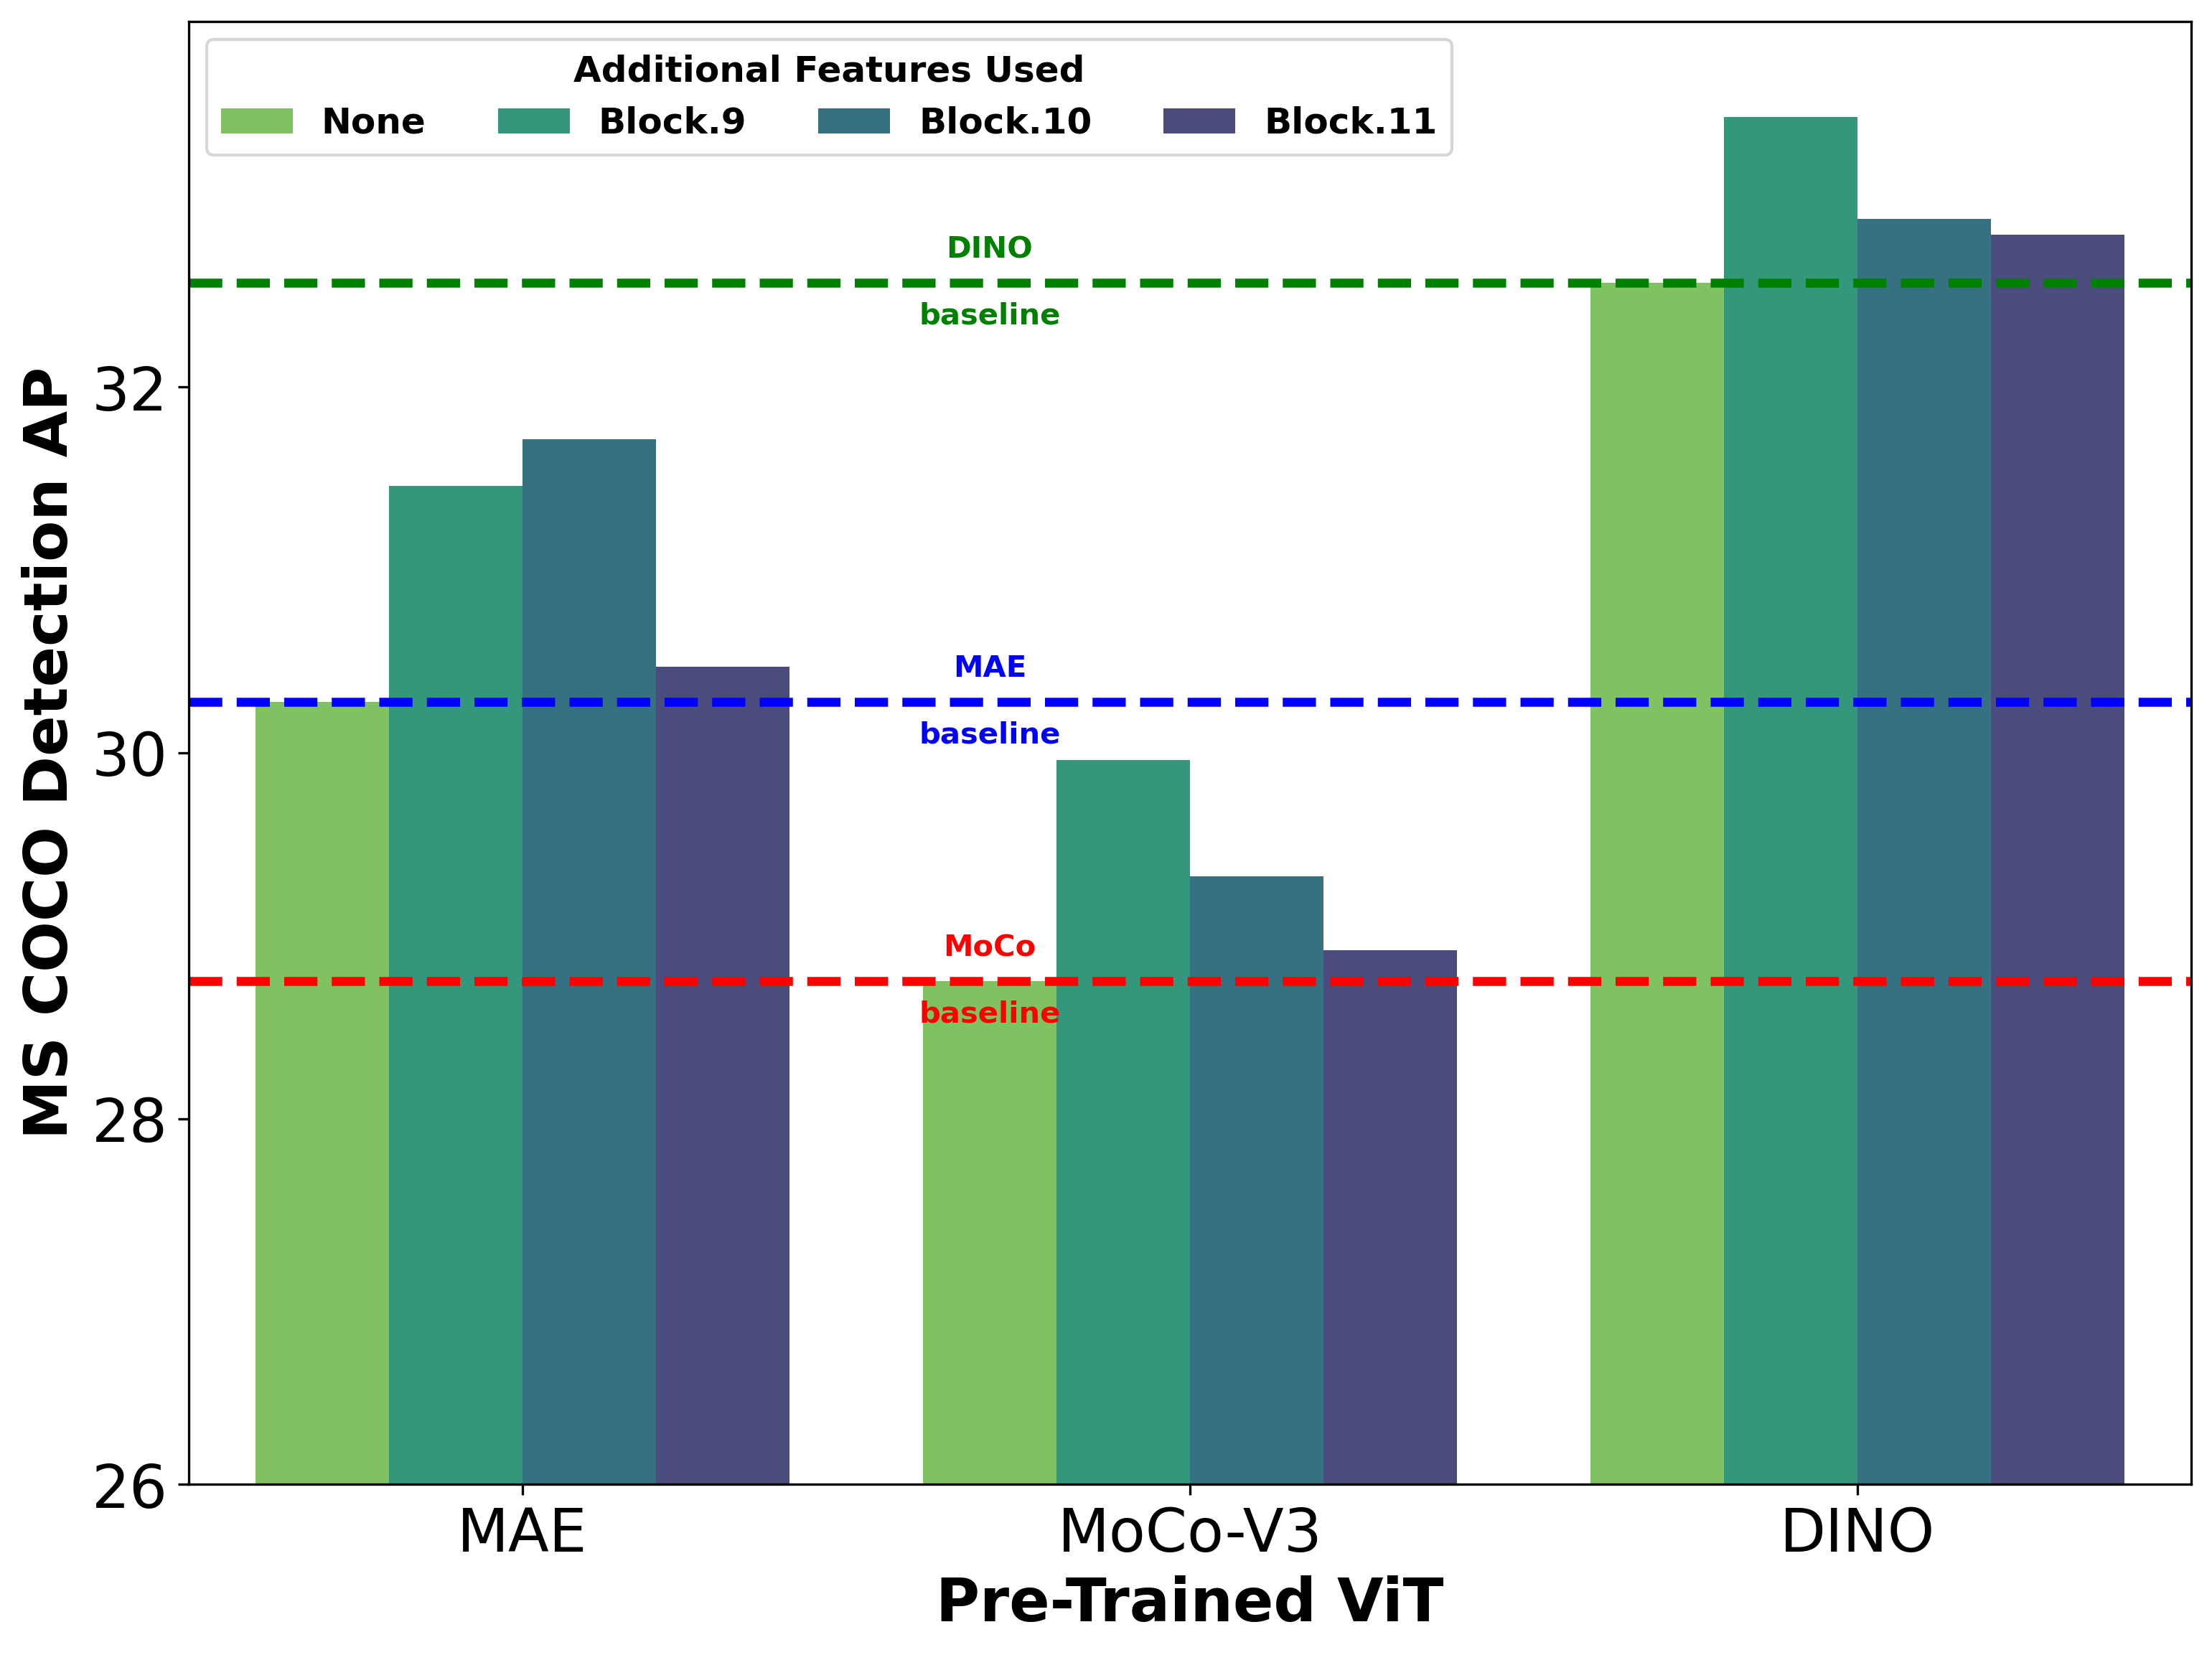

In [27]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

plot = sns.barplot(data=df, x='Model', y='bbox/AP', hue='Intermediate Features', palette=reversed(sns.color_palette("viridis", 4)))
print(plot)
plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.7, (df[(df['Model'] == 'MAE') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), 'MAE\n\nbaseline', fontsize=10, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='none')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(0.7, (df[(df['Model'] == 'MoCo') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), 'MoCo\n\nbaseline', fontsize=10, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='none')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(0.7, (df[(df['Model'] == 'DINO') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), 'DINO\n\nbaseline', fontsize=10, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='none')

ax.set_xlabel("Pre-Trained ViT", fontweight="bold", fontsize = 20)
ax.set_ylabel("MS COCO Detection AP", fontweight="bold", fontsize = 20)

plt.ylim([26, 34])

ax.set_xticklabels(['MAE', 'MoCo-V3', 'DINO'], fontsize = 20)
ax.set_yticks(np.arange(26, 34, 2), visible=True)
ax.set_yticklabels([x for x in np.arange(26, 34, 2)], fontsize = 20)

legend = plt.legend(loc='best', title="Additional Features Used", prop={'size': 12, 'weight':'bold'}, ncol=4)
plt.setp(legend.get_title(),fontsize=12, fontweight='bold')

fig.savefig(fig_dir + 'coco_marginal_features.pdf', dpi=500, bbox_inches = "tight")
plt.show() 